# One Shot Learning

Mit diesem Jupyter-Skript werden alle notwendigen Funktionen zur Umsetzung und Auswertung des OneShot-Learnings (Siamese Networks) von Ohrbildern zusammengefasst.  
Das Jupyter-Skript bezieht sich auf die Masterarbeit: "Verwendung des menschlichen Ohrs zur Personenauthentifizierung an IT-Systemen mittels CNNs".

## Bibliotheken importieren

Zunächst werden alle notwendigen Bibliothken importiert

In [105]:
## Import Libearies ##
%matplotlib inline
import cv2
from PIL import Image
import PIL.ImageOps 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os

## Import TORCHVISION with popular datasets, model architectures, 
## and common image transformations for computer vision
from torchvision import transforms
import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as dset
import torchsummary

# Import Debugging method for set_trace
from IPython.core.debugger import set_trace
import logging

## Import Time Features
import datetime
import time

## Import TORCH for Data-Structures for multi-dimensional tensors 
## and mathematical operations
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch_utils
from torch.autograd import Variable

# Import Winsound to play a *.wav-File
# and Counter for counting numbers in an array
import winsound
from collections import Counter

## Import Shutil to copy or delete Files
import shutil
from shutil import copyfile

## Import Random Libery
import random
from random import shuffle

## Import IPYWIDGET for interactive HTML widgets for Jupyter notebooks
import ipywidgets as wg
from IPython.display import display

## Festlegung: Prozessor oder Graphikkarte

In [106]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Funktion zur Gegenüberstellung zwei Ohren

Zwei Ohren werden gegenübergestellt und dazu der Constative-Loss Wert angezeigt

In [107]:
# build a rectangle in axes coords
left, width = 5, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

## Function to show Ear images and the Constrative Loss
def imshow(img,text=None,should_save=False):
    npimg = img.cpu().numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

## Function to show Learning-Curve with matplotlib
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Datensätze festlegen, anzeigen und einlesen

In [108]:
## Indirectr Path for Linux and Windows## 
def ChooseDir(datadir):
    if(datadir == 'CP'):
        return "Datensaetze/CP", "CP"
    if(datadir == 'AMI'):
        return "Datensaetze/AMI", "AMI"
    if(datadir == 'AWE'):
        return "Datensaetze/AWE", "AWE"
    if(datadir == 'EarVN'):
        return "Datensaetze/EarVN_1_0", "EarVN_1_0"
    if(datadir == 'UERC'):
        return "Datensaetze/UERC", "UERC"

## Voreinstellungen - Hilfsfunktionen

* **secs_to_HMS():** Berechnte Sekunden in HH:MM:SS um
* **WaitTime_Finished():** Gibt eine Audio-Datei aus, wenn Training und Testen beendet ist

In [109]:
## Convert Seconds to Hours, Minutes and Seconds ##
def secs_to_HMS(secs):
    if (secs < 3600):
        return datetime.datetime.fromtimestamp(secs).strftime('%M:%S'), "[MM:SS]"
    else:
        return datetime.datetime.fromtimestamp(secs).strftime('%H:%M:%S'), "[HH:MM:SS]"

## Acustic Sound if Model-Trainings finished ##
def WaitTime_Finished():
    for i in range(2):
        files=os.listdir("Sound/")
        file=random.choice(files)
        winsound.PlaySound("Sound/"+str(file), winsound.SND_FILENAME)
        time.sleep(2)

In [110]:
## Use actual Time for individual Tag ##
current_time = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
print(current_time)

2021_02_27-21_19_36


In [111]:
## All Networks from PyTorch wich can be pretrained ## 
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


def Network_Choice(netw):    
    if(netw == 'vgg11'):
        return models.vgg11(pretrained=True).to(DEVICE), "VGG11"
    if(netw == 'vgg11bn'):
        return models.vgg11_bn(pretrained=True).to(DEVICE), "VGG11bn"
    if(netw == 'resnet18'):
        return models.resnet18(pretrained=True).to(DEVICE), "ResNet18"
    if(netw == 'resnet34'):
        return models.resnet34(pretrained=True).to(DEVICE), "ResNet34"
    if(netw == 'alexnet'):
        return models.alexnet(pretrained=True).to(DEVICE), "AlexNet"
    if(netw == 'squeezenet1_0'):
        return models.squeezenet1_0(pretrained=True).to(DEVICE), "SqueezeNet-1-0"  
    if(netw == 'GoogLeNet'):
        return models.googlenet(pretrained=True).to(DEVICE), "GoogLeNet" 
    if(netw == 'shufflenet_v2_x0_5'):
        return models.shufflenet_v2_x0_5(pretrained=True).to(DEVICE), "Shufflenet-v2-x0_5"  
    if(netw == 'resnext101_32x8d'):
        return models.resnext101_32x8d(pretrained=True).to(DEVICE), "Resnext101-32x8d"
    if(netw == 'siamese'):
        return SiameseNetwork().to(DEVICE), 'Siamese_Network'

## Contrastive Loss

Constrive-Loss Berechnung für ein Siamese-Network 

In [112]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Konfiguration

Auswahl von: 
* Datensatz
* Netzwerk
* Trainshare
* Batch Size Train
* Batch Size Test
* Learning Rate
* Momentum

Hinweis: Konfiguration ausführen, Auswahl festlegen und weiter zum nächsten Abschnitt

In [113]:
datadir_choose = wg.Dropdown(
     options=['CP', 'AMI', 'AWE', 'EarVN', 'UERC'],
     value='AMI',
     description='Dataset:',
     disabled=False,
     button_style=''
)

network_string_choose = wg.Dropdown(
     options=['vgg11','vgg11bn','resnet18','resnet34','alexnet','squeezenet1_0','GoogLeNet','shufflenet_v2_x0_5','resnext101_32x8d', 'siamese'],
     value='vgg11',
     description='Network:',
     disabled=False,
     button_style=''
)

trainshare_choose = wg.BoundedFloatText(
     value=0.8,
     min=0,
     max=1,
     step=0.1,
     description='Trainshare:',
     disabled=False
)

batch_train = wg.BoundedIntText(
     value=4,
     min=1,
     max=100,
     step=1,
     description='Batch_Train:',
     disabled=False
)

batch_test = wg.BoundedIntText(
     value=4,
     min=1,
     max=100,
     step=1,
     description='Batch_Test:',
     disabled=False
)

learning_rate_choose = wg.BoundedFloatText(
     value=0.001,
     min=0,
     max=1,
     step=0.0001,
     description='Learning_Rate',
     disabled=False
)

momentum_choose = wg.BoundedFloatText(
     value=0.8,
     min=0,
     max=1,
     step=0.1,
     description='Momentum: ',
     disabled=False
)


display(datadir_choose, network_string_choose, trainshare_choose, batch_train, batch_test, learning_rate_choose, momentum_choose)

Dropdown(description='Dataset:', index=1, options=('CP', 'AMI', 'AWE', 'EarVN', 'UERC'), value='AMI')

Dropdown(description='Network:', options=('vgg11', 'vgg11bn', 'resnet18', 'resnet34', 'alexnet', 'squeezenet1_…

BoundedFloatText(value=0.8, description='Trainshare:', max=1.0, step=0.1)

BoundedIntText(value=4, description='Batch_Train:', min=1)

BoundedIntText(value=4, description='Batch_Test:', min=1)

BoundedFloatText(value=0.001, description='Learning_Rate', max=1.0, step=0.0001)

BoundedFloatText(value=0.8, description='Momentum: ', max=1.0, step=0.1)

In [114]:
## Define Variables, Arrays for Dataset and Categories ##
dataset_train = []
dataset_test = []
CATEGORIES = []
#img_array = []
network_name = 'nix'

datadir = datadir_choose.value
network_string = network_string_choose.value
train_share = trainshare_choose.value
batch_size_train = batch_train.value
batch_size_test = batch_test.value
learning_rate = learning_rate_choose.value
momentum = momentum_choose.value

## Pfade zum OneShot-Learning

Pfade zu den AMI-Bildern für das Trainieren und Testen der Siamese/PyTorch-Netzwerke

In [115]:
class Config():
    ## Define Pathes for Train- and Test-Images
    path_OneShot_Train = "./Datensaetze/AMI_OneShot/OneShot_Train/"
    path_OneShot_Test = "./Datensaetze/AMI_OneShot/OneShot_Testing/" 

## Netzwerke und Datensätze einlesen

In [116]:
## Get Network and Network-Name
network, network_name = Network_Choice(network_string)
## Define Constrative-Loss as Loss-Function
criterion = ContrastiveLoss()
## Define Adam as optimizer
optimizer = optim.Adam(network.parameters(),lr = 0.0005 )

## Choose Datadirectory to the Dataset ##
DATADIR, Database = ChooseDir(datadir)
## Read and list all Categories of a Dataset 
CATEGORIES = os.listdir(DATADIR)

## Erstellung oder Löschen des Dataset-Folder für SiameseDataset_Ear

* **Create_OneShot_File_Images():**
Falls keine Bilder in *./Datensaetze/AMI_OneShot_Train'* oder *./Datensaetze/AMI_OneShot_Test'* vorhanden sind können diese mit *Create_OneShot_File_Images()*.  

* **Delete_OneShot_File_Images():**
Falls andere Datensätze als der AMI-Datensatz gewünscht sind, kann der AMI-Datensatz durch *Delete_OneShot_File_Images():* gelöscht werden 

In [117]:
## Create Dataset-Images for OneShot Learning
def Create_OneShot_File_Images():
    for category in CATEGORIES:
            path = os.path.join(DATADIR, category)
            class_num = CATEGORIES.index(category)+1
            count_train_share = (len(os.listdir(path)))*train_share
            counter = 1
            os_listdir = os.listdir(path)
            try:
                ## Create Folders in Train- and Test-Directories
                os.mkdir(Config.path_OneShot_Train+str(class_num))
                os.mkdir(Config.path_OneShot_Test+str(class_num))
            except OSError:
                print ("Creation of the directory %s failed" % Config.path_OneShot_Train)
            else:
                print ("Successfully created the directory %s " % Config.path_OneShot_Test)

            for img in os_listdir:
                try:
                    ## Copy all Images in Train- and Test-Directories
                    if(counter <= count_train_share):
                        shutil.copy(path+'/'+img, Config.path_OneShot_Train+str(class_num))
                        counter += 1
                    else:
                        shutil.copy(path+'/'+img, Config.path_OneShot_Test+str(class_num))
                except Exception as e:
                     pass
                    
## Delete Dataset-Images for OneShot Learning                   
def Delete_OneShot_File_Images():
    for category in CATEGORIES:
            class_num = CATEGORIES.index(category)#1
            count_train_share = (len(os.listdir(path)))*train_share
            counter = 1
            os_listdir = os.listdir(path)
            ## Delete all Directories and Images of One Shot Learning
            try:
                shutil.rmtree(Config.path_OneShot_Train+str(class_num))
                shutil.rmtree(Config.path_OneShot_Test+str(class_num))
            except OSError:
                print ("Deletion of the directory %s failed" % Config.path_OneShot_Train)
            else:
                print ("Successfully deleted the directory %s" % Config.path_OneShot_Train)

In [118]:
#Create_OneShot_File_Images()
#Delete_OneShot_File_Images()

Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI_OneShot/OneShot_Testing/ 
Successfully created the directory ./Datensaetze/AMI

## Klasse zur Erstellung der Bildpaare

* **SiameseDataset_Ears()**: Erstellt die identische Anzahl an gleichen und ungleichen Bildpaaren und transformiert die Bilder

In [119]:
## Create Dataset of Ear-Images for OneShot-Learning
class SiameseDataset_Ears(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        ## Get random Picture from Test-File
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found 
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        ## Load images and convert to RGB if PyTorch-Network is Choosen
        ## Load images and convert to Gray if Siamese-Network is Choosen
        if(network_name == ('VGG11' or 'VGG11bn' or 'ResNet18' or 'ResNet34' or 'alexnet' or 'Squeezenet1_0' or 'GoogLeNet' or 'Shufflenet_v2_x0_5' or 'Resnext101_32x8d')):
            img0 = Image.open(img0_tuple[0]).convert('RGB')
            img1 = Image.open(img1_tuple[0]).convert('RGB')    
        elif(network_name == ('Siamese_Network')):
            img0 = Image.open(img0_tuple[0]).convert("L")
            img1 = Image.open(img1_tuple[0]).convert("L")
            #img0 = img0.convert("L")
            #img1 = img1.convert("L")
        else:
            print('False Network choosen')   
           
        ## Invert loaded PIL images
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
        
        ## Transform 
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Definition des Trainings- und Test-Folders

In [120]:
## Folder for Train-Images
folder_dataset_train = dset.ImageFolder(root=Config.path_OneShot_Train)

## Folder for Test-Images
folder_dataset_test = dset.ImageFolder(root=Config.path_OneShot_Test)

## Definition des Transformers

In [121]:
transformer = transforms.ToTensor()

## Define Transformer for PyTorch-Networks or Siamese Network
if(network_name == ('VGG11' or 'VGG11bn' or 'ResNet18' or 'ResNet34' or 'alexnet' or 'Squeezenet1_0' or 'GoogLeNet' or 'Shufflenet_v2_x0_5' or 'Resnext101_32x8d')):
    ## Transformer for PyTorch-Network
    transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4318, 0.4660, 0.5889), (0.1752, 0.1893, 0.2096)),
])

elif(network_name == ('Siamese_Network')):
    ## Transformer for Siamese-Network
    transformer=transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()
                                ])
else:
    print('False Network choosen')

## Laden von Train- und Testdatensätzen mit Transformation

In [122]:
## For PyTorch-Networks
siamese_dataset_train = SiameseDataset_Ears(imageFolderDataset=folder_dataset_train,
                                        transform=transformer,
                                        should_invert=False)

## Create Test-Dataset
siamese_dataset_test = SiameseDataset_Ears(imageFolderDataset=folder_dataset_test,
                                        transform=transformer,
                                        should_invert=True)



## Create Training-DataLoader
train_dataloader = DataLoader(siamese_dataset_train, batch_size=batch_size_train, shuffle=True,)

## Create Test-DataLoader
test_dataloader = DataLoader(siamese_dataset_test, batch_size=batch_size_test, shuffle=True)

## Visualisierung der Bildpaare des TrainLoaders
 
Bildpaare:  *Proband1 oben, Proband2 unten*  
0: Gleiches Paar  
1: Ungleiches Paar

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


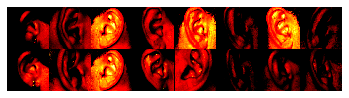

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [123]:
vis_dataloader = DataLoader(siamese_dataset_train, shuffle=True, batch_size=8)

dataiter = iter(vis_dataloader)

#example_batch = next(dataiter)
example_batch = dataiter.next()
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Training:

Start Training um:  21:20:32
Epoch number 0
 Current loss 308.1065979003906

Epoch number 0
 Current loss 1.138925552368164

Epoch number 0
 Current loss 0.964200496673584

Epoch number 1
 Current loss 1.052968978881836

Epoch number 1
 Current loss 0.9594541788101196

Epoch number 1
 Current loss 0.4107712507247925

Epoch number 2
 Current loss 1.5126802921295166

Epoch number 2
 Current loss 1.127558946609497

Epoch number 2
 Current loss 3.7104902267456055

Epoch number 3
 Current loss 0.7310527563095093

Epoch number 3
 Current loss 0.7123371362686157

Epoch number 3
 Current loss 1.3404734134674072

Epoch number 4
 Current loss 1.0322986841201782

Epoch number 4
 Current loss 1.4310665130615234

Epoch number 4
 Current loss 0.8324761390686035

Epoch number 5
 Current loss 0.8502787351608276

Epoch number 5
 Current loss 1.3122851848602295

Epoch number 5
 Current loss 0.921744167804718

Epoch number 6
 Current loss 1.1442584991455078

Epoch number 6
 Current loss 1.011681318283081

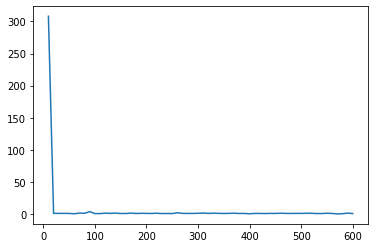

In [124]:
epoch_range = 20
counter = []
loss_history = [] 
iteration_number= 0


## Start Training
print("Start Training um: ", time.strftime("%H:%M:%S"))
start_time = time.time()

for epoch in range(epoch_range):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)

        optimizer.zero_grad()
        
        ## Calculate Ouputs and LossConstrative
        if(network_name == ('VGG11' or 'VGG11bn' or 'ResNet18' or 'ResNet34' or 'alexnet' or 'Squeezenet1_0' or 'GoogLeNet' or 'Shufflenet_v2_x0_5' or 'Resnext101_32x8d')):
            output1 = network(img0)
            output2 = network(img1)
            loss_contrastive = criterion(output1,output2,label)
           
        elif(network_name == ('Siamese_Network')):
            output1, output2 = network(img0, img1)
            #outputs = network(img0, img1)
            loss_contrastive = criterion(output1,output2,label)
        else:
            print('False Network choosen')
        
        
        ## Backpropagation and Optmizer
        loss_contrastive.backward()
        optimizer.step()
        
        ## Get loss
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

            
## Finished Training
print("Ende  Training um: ",time.strftime("%H:%M:%S"))
stop_time = time.time()
time_dif, time_format = secs_to_HMS(stop_time-start_time)
print("Dauer Training: ", time_dif, " ", time_format, " \n")            

show_plot(counter,loss_history)
WaitTime_Finished()

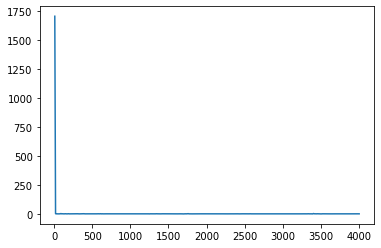

In [63]:
show_plot(counter,loss_history)

## Speichern der trainierten Netzwerke

In [125]:
## Path to save Network 
PATH = './Netzwerke_OneShot/' + current_time + '_' + Database + '_' + network_name + '_Train' + '.pth'

## Save Network
torch.save({
                'epoch_range': epoch_range,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_contrastive
            }, PATH)

## Testen

In [126]:
folder_dataset_test = dset.ImageFolder(root=Config.path_OneShot_Test)

siamese_dataset = SiameseDataset_Ears(imageFolderDataset=folder_dataset_test,
                                        transform=transformer
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,batch_size=1,shuffle=True)

## Test Function for Siamese-Network
def evaluation(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        count = 0

        for mainImg, imgSets, label in test_loader:
            mainImg, imgSets, label = mainImg.to(DEVICE), imgSets.to(DEVICE), label.to(DEVICE)
            predVal = 2.1
            pred = -1
            count += 1
            
            ## Determine which category an image belongs to
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(DEVICE)

            if(network_name == ('VGG11' or 'VGG11bn' or 'ResNet18' or 'ResNet34' or 'alexnet' or 'Squeezenet1_0' or 'GoogLeNet' or 'Shufflenet_v2_x0_5' or 'Resnext101_32x8d')):
                output1 = network(mainImg)
                output2 = network(imgSets)
                
            elif(network_name == ('Siamese_Network')):
                output1, output2 = network(mainImg, imgSets)
                
            else:
                print('False Network choosen')

      
            euclidean_distance = F.pairwise_distance(output1, output2)
            euclidean_distance = euclidean_distance.cpu().numpy()
            

            if(((euclidean_distance < predVal) and (label==0)) or ((euclidean_distance > predVal) and (label==1))):
                correct += 1
            print('Accuracy: {}'.format(correct/count))

In [127]:
evaluation(network, test_dataloader)

Accuracy: 1.0
Accuracy: 0.5
Accuracy: 0.3333333333333333
Accuracy: 0.25
Accuracy: 0.4
Accuracy: 0.3333333333333333
Accuracy: 0.2857142857142857
Accuracy: 0.375
Accuracy: 0.3333333333333333
Accuracy: 0.3
Accuracy: 0.2727272727272727
Accuracy: 0.25
Accuracy: 0.3076923076923077
Accuracy: 0.35714285714285715
Accuracy: 0.4
Accuracy: 0.375
Accuracy: 0.35294117647058826
Accuracy: 0.3888888888888889
Accuracy: 0.42105263157894735
Accuracy: 0.45
Accuracy: 0.42857142857142855
Accuracy: 0.4090909090909091
Accuracy: 0.391304347826087
Accuracy: 0.375
Accuracy: 0.4
Accuracy: 0.38461538461538464
Accuracy: 0.37037037037037035
Accuracy: 0.39285714285714285
Accuracy: 0.3793103448275862
Accuracy: 0.36666666666666664
Accuracy: 0.3870967741935484
Accuracy: 0.375
Accuracy: 0.3939393939393939
Accuracy: 0.4117647058823529
Accuracy: 0.42857142857142855
Accuracy: 0.4166666666666667
Accuracy: 0.40540540540540543
Accuracy: 0.42105263157894735
Accuracy: 0.4358974358974359
Accuracy: 0.45
